In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('train_with_mean_encoded_features.csv')
#test_df = pd.read_csv('test_df_with_mean_encoded_features.csv')
random_state = 42
np.random.seed(random_state)

In [4]:
train_df.head()

,id,product_number,department,category,creditCard,customer,var_32,var_33,var_34,var_35,...,category_mean_target,creditCard_mean_target,customer_mean_target,var_33_mean_target,var_34_mean_target,var_35_mean_target,var_36_mean_target,var_37_mean_target,var_38_mean_target,var_39_mean_target
0,id_11149922,5072,1852,25,6447,928147,0.725899,3,2,115,...,0.010425,0.060546,0.051885,0.046608,0.046534,0.031729,0.047143,0.033316,0.057354,0.039927
1,id_15609305,4751,2212,6,1813,928147,-1.023377,3,2,215,...,0.036223,0.110795,0.051882,0.046599,0.046526,0.028288,0.047108,0.049750,0.072953,0.032318
2,id_5222335,5817,528,2,6447,928147,-0.517814,3,2,55,...,0.064893,0.060546,0.051885,0.046608,0.046534,0.057632,0.047143,0.049685,0.058544,0.057192
3,id_1884252,3088,3682,24,6447,928147,-0.395321,3,2,6,...,0.053253,0.060526,0.051856,0.046606,0.046533,0.079156,0.097923,0.076529,0.072841,0.072297
4,id_12069677,2158,2204,24,6447,928147,0.610663,3,2,62,...,0.053297,0.060553,0.051873,0.046592,0.046521,0.033989,0.043381,0.046724,0.053007,0.065250


In [5]:
train_df["var_32_round_2"]=round(train_df.var_32,2)
train_df["var_32_round_3"]=round(train_df.var_32,3)
train_df["total_squared"]=train_df.total**2
train_df["total_3"]=train_df.total**3
train_df["var35_var38"]=train_df.var_35*train_df.var_38
train_df["var33_var34"]=train_df.var_33*train_df.var_34
train_df["var37_var39"]=train_df.var_37*train_df.var_39

In [6]:
cat_features=['product_number', 'department', 'category', 'creditCard','customer','var_32', 'var_32_round_2','var_32_round_3', 'var_33', 'var_34', 'var_35', 'var_36', 'var_37','var_38', 'var_39','var35_var38', 'var33_var34', 'var37_var39']
train_df[cat_features].head()

,product_number,department,category,creditCard,customer,var_32,var_32_round_2,var_32_round_3,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var35_var38,var33_var34,var37_var39
0,5072,1852,25,6447,928147,0.725899,0.73,0.726,3,2,115,0,44,62,12,7130,6,528
1,4751,2212,6,1813,928147,-1.023377,-1.02,-1.023,3,2,215,0,2,110,39,23650,6,78
2,5817,528,2,6447,928147,-0.517814,-0.52,-0.518,3,2,55,0,2,0,20,0,6,40
3,3088,3682,24,6447,928147,-0.395321,-0.40,-0.395,3,2,6,2,4,110,6,660,6,24
4,2158,2204,24,6447,928147,0.610663,0.61,0.611,3,2,62,3,11,59,5,3658,6,55


In [7]:
num_cols=['product_number', 'department', 'category', 'creditCard', 'customer','var_33','var_34', 'var_35', 'var_36', 'var_37', 'var_38', 'var_39','var35_var38','var33_var34','var37_var39']                     
for col in num_cols:
    train_df[col]=train_df[col].astype('int32')
float_cols=['product_number_mean_target',
       'department_mean_target', 'category_mean_target',
       'creditCard_mean_target', 'customer_mean_target', 'var_33_mean_target',
       'var_34_mean_target', 'var_35_mean_target', 'var_36_mean_target',
       'var_37_mean_target', 'var_38_mean_target', 'var_39_mean_target',
       'var_32_round_2', 'var_32_round_3', 'total_squared', 'total_3','total']
for col in float_cols:
    train_df[col]=train_df[col].astype('float32')

In [12]:
test_df = pd.read_csv('test_df_with_mean_encoded_features.csv')
test_df["var_32_round_2"]=round(test_df.var_32,2)
test_df["var_32_round_3"]=round(test_df.var_32,3)
test_df["total_squared"]=test_df.total**2
test_df["total_3"]=test_df.total**3
test_df["var35_var38"]=test_df.var_35*test_df.var_38
test_df["var33_var34"]=test_df.var_33*test_df.var_34
test_df["var37_var39"]=test_df.var_37*test_df.var_39
print(train_df.shape)
print(test_df.shape)

(10964602, 35)
(5220160, 34)


In [13]:
features = [c for c in train_df.columns if c not in ['id', 'target']]
target = train_df['target']
param = {         
    'bagging_fraction': 0.4,   
    'boost': 'gbdt',             'feature_fraction': 0.3,     'learning_rate': 0.083,
    'max_depth': -1,             'metric':'auc',                'min_data_in_leaf': 80,
    'num_leaves': 15,            'num_threads': 4,              'tree_learner': 'serial',   'objective': 'binary',      'verbosity': 1
}
folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=2319)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    clf = lgb.train(param, trn_data, 10000, valid_sets = [trn_data, val_data], early_stopping_rounds = 200,categorical_feature=cat_features)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    #predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration)
    #print("CV score: {:<8.5f}".format(roc_auc_score(target[val_idx], oof[val_idx])))
    break;
sub = pd.DataFrame({"id": test_df.id.values})
sub["target"] = predictions
sub.to_csv("features_interaction__80_data_mean_encoded_lgb_10000.csv", index=False)

Fold 0
[1]	training's auc: 0.700164	valid_1's auc: 0.70033
Training until validation scores don't improve for 200 rounds.
[2]	training's auc: 0.713568	valid_1's auc: 0.713842
[3]	training's auc: 0.718269	valid_1's auc: 0.718485
[4]	training's auc: 0.723786	valid_1's auc: 0.72409
[5]	training's auc: 0.731197	valid_1's auc: 0.731827
[6]	training's auc: 0.732037	valid_1's auc: 0.732736
[7]	training's auc: 0.73195	valid_1's auc: 0.732708
[8]	training's auc: 0.734091	valid_1's auc: 0.734763
[9]	training's auc: 0.735428	valid_1's auc: 0.736098
[10]	training's auc: 0.7352	valid_1's auc: 0.735871
[11]	training's auc: 0.735007	valid_1's auc: 0.735698
[12]	training's auc: 0.734776	valid_1's auc: 0.735458
[13]	training's auc: 0.734858	valid_1's auc: 0.73557
[14]	training's auc: 0.735657	valid_1's auc: 0.736437
[15]	training's auc: 0.736601	valid_1's auc: 0.737336
[16]	training's auc: 0.73627	valid_1's auc: 0.737037
[17]	training's auc: 0.737896	valid_1's auc: 0.738601
[18]	training's auc: 0.73875

[152]	training's auc: 0.750613	valid_1's auc: 0.749421
[153]	training's auc: 0.750642	valid_1's auc: 0.749437
[154]	training's auc: 0.75066	valid_1's auc: 0.749453
[155]	training's auc: 0.750694	valid_1's auc: 0.749479
[156]	training's auc: 0.750713	valid_1's auc: 0.749486
[157]	training's auc: 0.750738	valid_1's auc: 0.749496
[158]	training's auc: 0.750766	valid_1's auc: 0.749512
[159]	training's auc: 0.750802	valid_1's auc: 0.749536
[160]	training's auc: 0.750829	valid_1's auc: 0.749551
[161]	training's auc: 0.750853	valid_1's auc: 0.749561
[162]	training's auc: 0.750873	valid_1's auc: 0.749568
[163]	training's auc: 0.750888	valid_1's auc: 0.749571
[164]	training's auc: 0.750904	valid_1's auc: 0.749582
[165]	training's auc: 0.750911	valid_1's auc: 0.749585
[166]	training's auc: 0.750925	valid_1's auc: 0.749583
[167]	training's auc: 0.750939	valid_1's auc: 0.749587
[168]	training's auc: 0.750951	valid_1's auc: 0.749596
[169]	training's auc: 0.75097	valid_1's auc: 0.749611
[170]	traini

[302]	training's auc: 0.752614	valid_1's auc: 0.750324
[303]	training's auc: 0.752642	valid_1's auc: 0.750343
[304]	training's auc: 0.752655	valid_1's auc: 0.750344
[305]	training's auc: 0.752665	valid_1's auc: 0.750351
[306]	training's auc: 0.752673	valid_1's auc: 0.75035
[307]	training's auc: 0.752679	valid_1's auc: 0.750351
[308]	training's auc: 0.752689	valid_1's auc: 0.750357
[309]	training's auc: 0.752718	valid_1's auc: 0.750373
[310]	training's auc: 0.752729	valid_1's auc: 0.75038
[311]	training's auc: 0.752736	valid_1's auc: 0.750383
[312]	training's auc: 0.752749	valid_1's auc: 0.750383
[313]	training's auc: 0.752761	valid_1's auc: 0.750383
[314]	training's auc: 0.752781	valid_1's auc: 0.750389
[315]	training's auc: 0.752797	valid_1's auc: 0.750398
[316]	training's auc: 0.752814	valid_1's auc: 0.750407
[317]	training's auc: 0.75282	valid_1's auc: 0.750406
[318]	training's auc: 0.752835	valid_1's auc: 0.750414
[319]	training's auc: 0.752842	valid_1's auc: 0.750419
[320]	trainin

[452]	training's auc: 0.754125	valid_1's auc: 0.750978
[453]	training's auc: 0.754132	valid_1's auc: 0.750982
[454]	training's auc: 0.754135	valid_1's auc: 0.750984
[455]	training's auc: 0.754141	valid_1's auc: 0.750988
[456]	training's auc: 0.754145	valid_1's auc: 0.750987
[457]	training's auc: 0.754149	valid_1's auc: 0.750989
[458]	training's auc: 0.754167	valid_1's auc: 0.750995
[459]	training's auc: 0.754176	valid_1's auc: 0.750993
[460]	training's auc: 0.754182	valid_1's auc: 0.750994
[461]	training's auc: 0.754191	valid_1's auc: 0.750997
[462]	training's auc: 0.754195	valid_1's auc: 0.751
[463]	training's auc: 0.754202	valid_1's auc: 0.751001
[464]	training's auc: 0.754206	valid_1's auc: 0.751004
[465]	training's auc: 0.754207	valid_1's auc: 0.751003
[466]	training's auc: 0.754211	valid_1's auc: 0.751
[467]	training's auc: 0.754216	valid_1's auc: 0.750999
[468]	training's auc: 0.754224	valid_1's auc: 0.750998
[469]	training's auc: 0.754239	valid_1's auc: 0.750997
[470]	training's

[602]	training's auc: 0.755128	valid_1's auc: 0.751342
[603]	training's auc: 0.755139	valid_1's auc: 0.751349
[604]	training's auc: 0.755147	valid_1's auc: 0.751349
[605]	training's auc: 0.755152	valid_1's auc: 0.751349
[606]	training's auc: 0.75516	valid_1's auc: 0.751352
[607]	training's auc: 0.755169	valid_1's auc: 0.751356
[608]	training's auc: 0.755176	valid_1's auc: 0.751359
[609]	training's auc: 0.755179	valid_1's auc: 0.751359
[610]	training's auc: 0.755198	valid_1's auc: 0.751374
[611]	training's auc: 0.755204	valid_1's auc: 0.751374
[612]	training's auc: 0.755209	valid_1's auc: 0.751376
[613]	training's auc: 0.755213	valid_1's auc: 0.751377
[614]	training's auc: 0.755226	valid_1's auc: 0.751379
[615]	training's auc: 0.755236	valid_1's auc: 0.75138
[616]	training's auc: 0.755238	valid_1's auc: 0.75138
[617]	training's auc: 0.75525	valid_1's auc: 0.751379
[618]	training's auc: 0.755253	valid_1's auc: 0.751378
[619]	training's auc: 0.755261	valid_1's auc: 0.75138
[620]	training'

[752]	training's auc: 0.756019	valid_1's auc: 0.751555
[753]	training's auc: 0.756021	valid_1's auc: 0.751555
[754]	training's auc: 0.756025	valid_1's auc: 0.751555
[755]	training's auc: 0.756028	valid_1's auc: 0.751553
[756]	training's auc: 0.756034	valid_1's auc: 0.751554
[757]	training's auc: 0.756039	valid_1's auc: 0.751554
[758]	training's auc: 0.756042	valid_1's auc: 0.751554
[759]	training's auc: 0.756045	valid_1's auc: 0.751556
[760]	training's auc: 0.756055	valid_1's auc: 0.751558
[761]	training's auc: 0.756069	valid_1's auc: 0.751566
[762]	training's auc: 0.756076	valid_1's auc: 0.751566
[763]	training's auc: 0.756082	valid_1's auc: 0.751566
[764]	training's auc: 0.756087	valid_1's auc: 0.751564
[765]	training's auc: 0.756088	valid_1's auc: 0.751564
[766]	training's auc: 0.756094	valid_1's auc: 0.751564
[767]	training's auc: 0.756095	valid_1's auc: 0.751564
[768]	training's auc: 0.756098	valid_1's auc: 0.751565
[769]	training's auc: 0.756103	valid_1's auc: 0.751568
[770]	trai

[902]	training's auc: 0.756757	valid_1's auc: 0.751693
[903]	training's auc: 0.75676	valid_1's auc: 0.751694
[904]	training's auc: 0.756769	valid_1's auc: 0.751698
[905]	training's auc: 0.756778	valid_1's auc: 0.751698
[906]	training's auc: 0.756779	valid_1's auc: 0.751697
[907]	training's auc: 0.75678	valid_1's auc: 0.751699
[908]	training's auc: 0.756786	valid_1's auc: 0.751697
[909]	training's auc: 0.756794	valid_1's auc: 0.751698
[910]	training's auc: 0.756802	valid_1's auc: 0.751698
[911]	training's auc: 0.756819	valid_1's auc: 0.751707
[912]	training's auc: 0.756822	valid_1's auc: 0.751708
[913]	training's auc: 0.756824	valid_1's auc: 0.751707
[914]	training's auc: 0.756827	valid_1's auc: 0.751706
[915]	training's auc: 0.756835	valid_1's auc: 0.751711
[916]	training's auc: 0.756837	valid_1's auc: 0.75171
[917]	training's auc: 0.75684	valid_1's auc: 0.75171
[918]	training's auc: 0.756856	valid_1's auc: 0.751714
[919]	training's auc: 0.75686	valid_1's auc: 0.751715
[920]	training's

[1051]	training's auc: 0.757404	valid_1's auc: 0.751805
[1052]	training's auc: 0.757408	valid_1's auc: 0.751805
[1053]	training's auc: 0.757412	valid_1's auc: 0.751805
[1054]	training's auc: 0.757417	valid_1's auc: 0.751807
[1055]	training's auc: 0.75743	valid_1's auc: 0.751807
[1056]	training's auc: 0.757449	valid_1's auc: 0.751815
[1057]	training's auc: 0.757463	valid_1's auc: 0.751821
[1058]	training's auc: 0.757466	valid_1's auc: 0.751821
[1059]	training's auc: 0.757467	valid_1's auc: 0.751822
[1060]	training's auc: 0.757474	valid_1's auc: 0.751827
[1061]	training's auc: 0.757481	valid_1's auc: 0.751825
[1062]	training's auc: 0.757483	valid_1's auc: 0.751824
[1063]	training's auc: 0.757488	valid_1's auc: 0.751828
[1064]	training's auc: 0.757491	valid_1's auc: 0.751829
[1065]	training's auc: 0.757495	valid_1's auc: 0.75183
[1066]	training's auc: 0.757497	valid_1's auc: 0.751829
[1067]	training's auc: 0.757499	valid_1's auc: 0.75183
[1068]	training's auc: 0.757502	valid_1's auc: 0.75

[1198]	training's auc: 0.758081	valid_1's auc: 0.751962
[1199]	training's auc: 0.758084	valid_1's auc: 0.751963
[1200]	training's auc: 0.758085	valid_1's auc: 0.751963
[1201]	training's auc: 0.758091	valid_1's auc: 0.751964
[1202]	training's auc: 0.758094	valid_1's auc: 0.751964
[1203]	training's auc: 0.7581	valid_1's auc: 0.751968
[1204]	training's auc: 0.758118	valid_1's auc: 0.751964
[1205]	training's auc: 0.758121	valid_1's auc: 0.751965
[1206]	training's auc: 0.758144	valid_1's auc: 0.75197
[1207]	training's auc: 0.758147	valid_1's auc: 0.751971
[1208]	training's auc: 0.75815	valid_1's auc: 0.751973
[1209]	training's auc: 0.758153	valid_1's auc: 0.751973
[1210]	training's auc: 0.758157	valid_1's auc: 0.751973
[1211]	training's auc: 0.75816	valid_1's auc: 0.751975
[1212]	training's auc: 0.758164	valid_1's auc: 0.751974
[1213]	training's auc: 0.758167	valid_1's auc: 0.751975
[1214]	training's auc: 0.758171	valid_1's auc: 0.751973
[1215]	training's auc: 0.758175	valid_1's auc: 0.7519

[1345]	training's auc: 0.758726	valid_1's auc: 0.752083
[1346]	training's auc: 0.758727	valid_1's auc: 0.752083
[1347]	training's auc: 0.758728	valid_1's auc: 0.752083
[1348]	training's auc: 0.758738	valid_1's auc: 0.75209
[1349]	training's auc: 0.758741	valid_1's auc: 0.752091
[1350]	training's auc: 0.758744	valid_1's auc: 0.752093
[1351]	training's auc: 0.758747	valid_1's auc: 0.752092
[1352]	training's auc: 0.758751	valid_1's auc: 0.752091
[1353]	training's auc: 0.758753	valid_1's auc: 0.752091
[1354]	training's auc: 0.758756	valid_1's auc: 0.75209
[1355]	training's auc: 0.758757	valid_1's auc: 0.752091
[1356]	training's auc: 0.758762	valid_1's auc: 0.752091
[1357]	training's auc: 0.758764	valid_1's auc: 0.752089
[1358]	training's auc: 0.758765	valid_1's auc: 0.752088
[1359]	training's auc: 0.758767	valid_1's auc: 0.752089
[1360]	training's auc: 0.75878	valid_1's auc: 0.752093
[1361]	training's auc: 0.758784	valid_1's auc: 0.752092
[1362]	training's auc: 0.758791	valid_1's auc: 0.75

[1492]	training's auc: 0.759257	valid_1's auc: 0.752148
[1493]	training's auc: 0.759261	valid_1's auc: 0.752149
[1494]	training's auc: 0.759263	valid_1's auc: 0.752148
[1495]	training's auc: 0.759264	valid_1's auc: 0.752147
[1496]	training's auc: 0.759266	valid_1's auc: 0.752145
[1497]	training's auc: 0.759269	valid_1's auc: 0.752146
[1498]	training's auc: 0.759272	valid_1's auc: 0.752146
[1499]	training's auc: 0.759275	valid_1's auc: 0.752149
[1500]	training's auc: 0.759276	valid_1's auc: 0.752149
[1501]	training's auc: 0.759282	valid_1's auc: 0.75215
[1502]	training's auc: 0.759286	valid_1's auc: 0.752151
[1503]	training's auc: 0.759287	valid_1's auc: 0.752151
[1504]	training's auc: 0.75929	valid_1's auc: 0.752151
[1505]	training's auc: 0.759292	valid_1's auc: 0.752149
[1506]	training's auc: 0.759294	valid_1's auc: 0.75215
[1507]	training's auc: 0.759299	valid_1's auc: 0.752151
[1508]	training's auc: 0.759302	valid_1's auc: 0.752151
[1509]	training's auc: 0.759302	valid_1's auc: 0.75

[1639]	training's auc: 0.759707	valid_1's auc: 0.752162
[1640]	training's auc: 0.759714	valid_1's auc: 0.752165
[1641]	training's auc: 0.75972	valid_1's auc: 0.752165
[1642]	training's auc: 0.759723	valid_1's auc: 0.752165
[1643]	training's auc: 0.759729	valid_1's auc: 0.752163
[1644]	training's auc: 0.759732	valid_1's auc: 0.75216
[1645]	training's auc: 0.759733	valid_1's auc: 0.75216
[1646]	training's auc: 0.759735	valid_1's auc: 0.75216
[1647]	training's auc: 0.759739	valid_1's auc: 0.752162
[1648]	training's auc: 0.759741	valid_1's auc: 0.752164
[1649]	training's auc: 0.759744	valid_1's auc: 0.752165
[1650]	training's auc: 0.759746	valid_1's auc: 0.752166
[1651]	training's auc: 0.759748	valid_1's auc: 0.752165
[1652]	training's auc: 0.75975	valid_1's auc: 0.752164
[1653]	training's auc: 0.759755	valid_1's auc: 0.752163
[1654]	training's auc: 0.75976	valid_1's auc: 0.752163
[1655]	training's auc: 0.759762	valid_1's auc: 0.752164
[1656]	training's auc: 0.759763	valid_1's auc: 0.75216

[1787]	training's auc: 0.760178	valid_1's auc: 0.752199
[1788]	training's auc: 0.760184	valid_1's auc: 0.7522
[1789]	training's auc: 0.760184	valid_1's auc: 0.752199
[1790]	training's auc: 0.760187	valid_1's auc: 0.752201
[1791]	training's auc: 0.760191	valid_1's auc: 0.752203
[1792]	training's auc: 0.760192	valid_1's auc: 0.752203
[1793]	training's auc: 0.760198	valid_1's auc: 0.752206
[1794]	training's auc: 0.7602	valid_1's auc: 0.752206
[1795]	training's auc: 0.760218	valid_1's auc: 0.752207
[1796]	training's auc: 0.76022	valid_1's auc: 0.752207
[1797]	training's auc: 0.760221	valid_1's auc: 0.752207
[1798]	training's auc: 0.760224	valid_1's auc: 0.752204
[1799]	training's auc: 0.760236	valid_1's auc: 0.752207
[1800]	training's auc: 0.760239	valid_1's auc: 0.752205
[1801]	training's auc: 0.76024	valid_1's auc: 0.752204
[1802]	training's auc: 0.760244	valid_1's auc: 0.752203
[1803]	training's auc: 0.76025	valid_1's auc: 0.752204
[1804]	training's auc: 0.760251	valid_1's auc: 0.752205

[1935]	training's auc: 0.760708	valid_1's auc: 0.752244
[1936]	training's auc: 0.76071	valid_1's auc: 0.752242
[1937]	training's auc: 0.760712	valid_1's auc: 0.752242
[1938]	training's auc: 0.760713	valid_1's auc: 0.752242
[1939]	training's auc: 0.760714	valid_1's auc: 0.752242
[1940]	training's auc: 0.760715	valid_1's auc: 0.752242
[1941]	training's auc: 0.760717	valid_1's auc: 0.752241
[1942]	training's auc: 0.76072	valid_1's auc: 0.752241
[1943]	training's auc: 0.760725	valid_1's auc: 0.75224
[1944]	training's auc: 0.760729	valid_1's auc: 0.752241
[1945]	training's auc: 0.760733	valid_1's auc: 0.752241
[1946]	training's auc: 0.760734	valid_1's auc: 0.75224
[1947]	training's auc: 0.760737	valid_1's auc: 0.75224
[1948]	training's auc: 0.760739	valid_1's auc: 0.752242
[1949]	training's auc: 0.760741	valid_1's auc: 0.752243
[1950]	training's auc: 0.760743	valid_1's auc: 0.752243
[1951]	training's auc: 0.760745	valid_1's auc: 0.752243
[1952]	training's auc: 0.760748	valid_1's auc: 0.7522

[2082]	training's auc: 0.761187	valid_1's auc: 0.752279
[2083]	training's auc: 0.761196	valid_1's auc: 0.752278
[2084]	training's auc: 0.761201	valid_1's auc: 0.752278
[2085]	training's auc: 0.761202	valid_1's auc: 0.752278
[2086]	training's auc: 0.761203	valid_1's auc: 0.752278
[2087]	training's auc: 0.761207	valid_1's auc: 0.752277
[2088]	training's auc: 0.761209	valid_1's auc: 0.752278
[2089]	training's auc: 0.761209	valid_1's auc: 0.752278
[2090]	training's auc: 0.761218	valid_1's auc: 0.752277
[2091]	training's auc: 0.761221	valid_1's auc: 0.752275
[2092]	training's auc: 0.761225	valid_1's auc: 0.752275
[2093]	training's auc: 0.761228	valid_1's auc: 0.752277
[2094]	training's auc: 0.761233	valid_1's auc: 0.752278
[2095]	training's auc: 0.761238	valid_1's auc: 0.752282
[2096]	training's auc: 0.761241	valid_1's auc: 0.752282
[2097]	training's auc: 0.761244	valid_1's auc: 0.752281
[2098]	training's auc: 0.761249	valid_1's auc: 0.75228
[2099]	training's auc: 0.761253	valid_1's auc: 0.

[2230]	training's auc: 0.761665	valid_1's auc: 0.752303
[2231]	training's auc: 0.761674	valid_1's auc: 0.752306
[2232]	training's auc: 0.761679	valid_1's auc: 0.752308
[2233]	training's auc: 0.761682	valid_1's auc: 0.752308
[2234]	training's auc: 0.761683	valid_1's auc: 0.752308
[2235]	training's auc: 0.761687	valid_1's auc: 0.752307
[2236]	training's auc: 0.761689	valid_1's auc: 0.752308
[2237]	training's auc: 0.761694	valid_1's auc: 0.752305
[2238]	training's auc: 0.761696	valid_1's auc: 0.752304
[2239]	training's auc: 0.761702	valid_1's auc: 0.752304
[2240]	training's auc: 0.761706	valid_1's auc: 0.752305
[2241]	training's auc: 0.761707	valid_1's auc: 0.752304
[2242]	training's auc: 0.761709	valid_1's auc: 0.752304
[2243]	training's auc: 0.761712	valid_1's auc: 0.752307
[2244]	training's auc: 0.761713	valid_1's auc: 0.752309
[2245]	training's auc: 0.761715	valid_1's auc: 0.752309
[2246]	training's auc: 0.761715	valid_1's auc: 0.752309
[2247]	training's auc: 0.761716	valid_1's auc: 0

[2377]	training's auc: 0.762053	valid_1's auc: 0.752322
[2378]	training's auc: 0.762062	valid_1's auc: 0.752323
[2379]	training's auc: 0.762064	valid_1's auc: 0.752322
[2380]	training's auc: 0.762066	valid_1's auc: 0.752323
[2381]	training's auc: 0.762072	valid_1's auc: 0.752325
[2382]	training's auc: 0.762074	valid_1's auc: 0.752324
[2383]	training's auc: 0.762075	valid_1's auc: 0.752323
[2384]	training's auc: 0.762079	valid_1's auc: 0.752322
[2385]	training's auc: 0.762081	valid_1's auc: 0.752321
[2386]	training's auc: 0.762082	valid_1's auc: 0.752321
[2387]	training's auc: 0.762091	valid_1's auc: 0.75232
[2388]	training's auc: 0.762095	valid_1's auc: 0.752319
[2389]	training's auc: 0.762097	valid_1's auc: 0.752317
[2390]	training's auc: 0.762098	valid_1's auc: 0.752317
[2391]	training's auc: 0.7621	valid_1's auc: 0.752317
[2392]	training's auc: 0.762103	valid_1's auc: 0.752316
[2393]	training's auc: 0.762103	valid_1's auc: 0.752316
[2394]	training's auc: 0.762104	valid_1's auc: 0.75

[2524]	training's auc: 0.76248	valid_1's auc: 0.75233
[2525]	training's auc: 0.762481	valid_1's auc: 0.752329
[2526]	training's auc: 0.762483	valid_1's auc: 0.75233
[2527]	training's auc: 0.762487	valid_1's auc: 0.75233
[2528]	training's auc: 0.762491	valid_1's auc: 0.752329
[2529]	training's auc: 0.762495	valid_1's auc: 0.75233
[2530]	training's auc: 0.762497	valid_1's auc: 0.752329
[2531]	training's auc: 0.762501	valid_1's auc: 0.752332
[2532]	training's auc: 0.762503	valid_1's auc: 0.752333
[2533]	training's auc: 0.762504	valid_1's auc: 0.752333
[2534]	training's auc: 0.762505	valid_1's auc: 0.752333
[2535]	training's auc: 0.762508	valid_1's auc: 0.752331
[2536]	training's auc: 0.762509	valid_1's auc: 0.752333
[2537]	training's auc: 0.762511	valid_1's auc: 0.752334
[2538]	training's auc: 0.762512	valid_1's auc: 0.752334
[2539]	training's auc: 0.762515	valid_1's auc: 0.752333
[2540]	training's auc: 0.762532	valid_1's auc: 0.752331
[2541]	training's auc: 0.762534	valid_1's auc: 0.7523

[2671]	training's auc: 0.762862	valid_1's auc: 0.752318
[2672]	training's auc: 0.762864	valid_1's auc: 0.752319
[2673]	training's auc: 0.762865	valid_1's auc: 0.752319
[2674]	training's auc: 0.762869	valid_1's auc: 0.752319
[2675]	training's auc: 0.76287	valid_1's auc: 0.752319
[2676]	training's auc: 0.762872	valid_1's auc: 0.752319
[2677]	training's auc: 0.762874	valid_1's auc: 0.752318
[2678]	training's auc: 0.762874	valid_1's auc: 0.752318
[2679]	training's auc: 0.762876	valid_1's auc: 0.752318
[2680]	training's auc: 0.762877	valid_1's auc: 0.752318
[2681]	training's auc: 0.762882	valid_1's auc: 0.752318
[2682]	training's auc: 0.762885	valid_1's auc: 0.752318
[2683]	training's auc: 0.762888	valid_1's auc: 0.752316
[2684]	training's auc: 0.76289	valid_1's auc: 0.752316
[2685]	training's auc: 0.762892	valid_1's auc: 0.752316
[2686]	training's auc: 0.762894	valid_1's auc: 0.752315
[2687]	training's auc: 0.762895	valid_1's auc: 0.752315
[2688]	training's auc: 0.762898	valid_1's auc: 0.7

In [23]:
folds = StratifiedKFold(n_splits=2, shuffle=False, random_state=2319)
train_half=pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, train_df.target.values)):
    print("Fold {}".format(fold_))
    train_half =train_df.iloc[trn_idx]
    break;

Fold 0


In [ ]:
param = {
    'bagging_freq': 5,          
    'bagging_fraction': 0.331,   'boost_from_average':'false',   
    'boost': 'gbdt',             'feature_fraction': 0.2,     'learning_rate': 0.083,
    'max_depth': -1,             'metric':'auc',                'min_data_in_leaf': 80,     'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,            'num_threads': 4,              'tree_learner': 'serial',   'objective': 'binary',      'verbosity': 1
}

# official pipeline:

# second submission

In [27]:
features = [c for c in train_df.columns if c not in ['id', 'target']]
target = train_half['target']
param = {
    'bagging_freq': 5,          
    'bagging_fraction': 0.331,   'boost_from_average':'false',   
    'boost': 'gbdt',             'feature_fraction': 0.2,     'learning_rate': 0.083,
    'max_depth': -1,             'metric':'auc',                'min_data_in_leaf': 80,
    'num_leaves': 13,            'num_threads': 4,              'tree_learner': 'serial',   'objective': 'binary',      'verbosity': 1
}
folds = StratifiedKFold(n_splits=2, shuffle=False, random_state=2319)
oof = np.zeros(len(train_half))
predictions = np.zeros(len(test_df))
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_half.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_half.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_half.iloc[val_idx][features], label=target.iloc[val_idx])
    clf = lgb.train(param, trn_data, 10000, valid_sets = [trn_data, val_data], early_stopping_rounds = 200,categorical_feature=cat_features)
    oof[val_idx] = clf.predict(train_half.iloc[val_idx][features], num_iteration=clf.best_iteration)
    #predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration)
    #print("CV score: {:<8.5f}".format(roc_auc_score(target[val_idx], oof[val_idx])))
    break;
sub = pd.DataFrame({"id": test_df.id.values})
sub["target"] = predictions
sub.to_csv("mean_encoded_lgb_10000.csv", index=False)

Fold 0
[1]	training's auc: 0.683422	valid_1's auc: 0.683753
Training until validation scores don't improve for 200 rounds.
[2]	training's auc: 0.688653	valid_1's auc: 0.688394
[3]	training's auc: 0.707967	valid_1's auc: 0.707536
[4]	training's auc: 0.714538	valid_1's auc: 0.714097
[5]	training's auc: 0.71803	valid_1's auc: 0.717818
[6]	training's auc: 0.716499	valid_1's auc: 0.716491
[7]	training's auc: 0.719199	valid_1's auc: 0.719357
[8]	training's auc: 0.718347	valid_1's auc: 0.718484
[9]	training's auc: 0.719494	valid_1's auc: 0.719621
[10]	training's auc: 0.72035	valid_1's auc: 0.720457
[11]	training's auc: 0.719685	valid_1's auc: 0.719783
[12]	training's auc: 0.724679	valid_1's auc: 0.724581
[13]	training's auc: 0.723533	valid_1's auc: 0.723361
[14]	training's auc: 0.724708	valid_1's auc: 0.724774
[15]	training's auc: 0.726993	valid_1's auc: 0.726865
[16]	training's auc: 0.726989	valid_1's auc: 0.726995
[17]	training's auc: 0.728007	valid_1's auc: 0.727975
[18]	training's auc: 0.

[152]	training's auc: 0.74778	valid_1's auc: 0.745092
[153]	training's auc: 0.747806	valid_1's auc: 0.745084
[154]	training's auc: 0.747852	valid_1's auc: 0.745137
[155]	training's auc: 0.747917	valid_1's auc: 0.745152
[156]	training's auc: 0.747937	valid_1's auc: 0.74517
[157]	training's auc: 0.747944	valid_1's auc: 0.745171
[158]	training's auc: 0.747958	valid_1's auc: 0.745185
[159]	training's auc: 0.748025	valid_1's auc: 0.745246
[160]	training's auc: 0.7481	valid_1's auc: 0.745266
[161]	training's auc: 0.74812	valid_1's auc: 0.745281
[162]	training's auc: 0.74815	valid_1's auc: 0.745302
[163]	training's auc: 0.748188	valid_1's auc: 0.745323
[164]	training's auc: 0.748372	valid_1's auc: 0.74547
[165]	training's auc: 0.748399	valid_1's auc: 0.745493
[166]	training's auc: 0.748435	valid_1's auc: 0.745511
[167]	training's auc: 0.748478	valid_1's auc: 0.745553
[168]	training's auc: 0.74852	valid_1's auc: 0.745581
[169]	training's auc: 0.748531	valid_1's auc: 0.745596
[170]	training's a

[302]	training's auc: 0.751542	valid_1's auc: 0.746995
[303]	training's auc: 0.751553	valid_1's auc: 0.747006
[304]	training's auc: 0.751558	valid_1's auc: 0.747012
[305]	training's auc: 0.75157	valid_1's auc: 0.747019
[306]	training's auc: 0.751727	valid_1's auc: 0.747144
[307]	training's auc: 0.751738	valid_1's auc: 0.747149
[308]	training's auc: 0.751755	valid_1's auc: 0.747165
[309]	training's auc: 0.751772	valid_1's auc: 0.747173
[310]	training's auc: 0.751781	valid_1's auc: 0.747162
[311]	training's auc: 0.751793	valid_1's auc: 0.747166
[312]	training's auc: 0.751805	valid_1's auc: 0.747165
[313]	training's auc: 0.751827	valid_1's auc: 0.747176
[314]	training's auc: 0.75184	valid_1's auc: 0.747163
[315]	training's auc: 0.751827	valid_1's auc: 0.747151
[316]	training's auc: 0.751841	valid_1's auc: 0.747158
[317]	training's auc: 0.751864	valid_1's auc: 0.74716
[318]	training's auc: 0.751886	valid_1's auc: 0.747162
[319]	training's auc: 0.751909	valid_1's auc: 0.747174
[320]	trainin

[452]	training's auc: 0.753932	valid_1's auc: 0.748102
[453]	training's auc: 0.753943	valid_1's auc: 0.748103
[454]	training's auc: 0.753954	valid_1's auc: 0.748102
[455]	training's auc: 0.754009	valid_1's auc: 0.748144
[456]	training's auc: 0.754027	valid_1's auc: 0.748173
[457]	training's auc: 0.754039	valid_1's auc: 0.748178
[458]	training's auc: 0.754062	valid_1's auc: 0.748189
[459]	training's auc: 0.754069	valid_1's auc: 0.748186
[460]	training's auc: 0.754076	valid_1's auc: 0.748191
[461]	training's auc: 0.754077	valid_1's auc: 0.748189
[462]	training's auc: 0.754082	valid_1's auc: 0.748196
[463]	training's auc: 0.75409	valid_1's auc: 0.748199
[464]	training's auc: 0.754101	valid_1's auc: 0.748189
[465]	training's auc: 0.754106	valid_1's auc: 0.748188
[466]	training's auc: 0.754121	valid_1's auc: 0.748185
[467]	training's auc: 0.754129	valid_1's auc: 0.748176
[468]	training's auc: 0.754131	valid_1's auc: 0.748164
[469]	training's auc: 0.754155	valid_1's auc: 0.748175
[470]	train

[602]	training's auc: 0.755695	valid_1's auc: 0.748635
[603]	training's auc: 0.755713	valid_1's auc: 0.748653
[604]	training's auc: 0.755747	valid_1's auc: 0.748683
[605]	training's auc: 0.755763	valid_1's auc: 0.748682
[606]	training's auc: 0.755783	valid_1's auc: 0.748697
[607]	training's auc: 0.755779	valid_1's auc: 0.748688
[608]	training's auc: 0.755782	valid_1's auc: 0.748693
[609]	training's auc: 0.75579	valid_1's auc: 0.748715
[610]	training's auc: 0.755778	valid_1's auc: 0.748699
[611]	training's auc: 0.755785	valid_1's auc: 0.748721
[612]	training's auc: 0.755793	valid_1's auc: 0.748727
[613]	training's auc: 0.755808	valid_1's auc: 0.74873
[614]	training's auc: 0.755819	valid_1's auc: 0.748733
[615]	training's auc: 0.755832	valid_1's auc: 0.748751
[616]	training's auc: 0.755856	valid_1's auc: 0.748757
[617]	training's auc: 0.755856	valid_1's auc: 0.748758
[618]	training's auc: 0.755874	valid_1's auc: 0.748766
[619]	training's auc: 0.755864	valid_1's auc: 0.748759
[620]	traini

[752]	training's auc: 0.757108	valid_1's auc: 0.749029
[753]	training's auc: 0.757128	valid_1's auc: 0.749027
[754]	training's auc: 0.757113	valid_1's auc: 0.749011
[755]	training's auc: 0.757102	valid_1's auc: 0.749004
[756]	training's auc: 0.757112	valid_1's auc: 0.749001
[757]	training's auc: 0.757128	valid_1's auc: 0.74901
[758]	training's auc: 0.75714	valid_1's auc: 0.749002
[759]	training's auc: 0.757147	valid_1's auc: 0.748996
[760]	training's auc: 0.757152	valid_1's auc: 0.748995
[761]	training's auc: 0.75716	valid_1's auc: 0.748996
[762]	training's auc: 0.757171	valid_1's auc: 0.749
[763]	training's auc: 0.757172	valid_1's auc: 0.748997
[764]	training's auc: 0.757179	valid_1's auc: 0.74899
[765]	training's auc: 0.75719	valid_1's auc: 0.748984
[766]	training's auc: 0.757204	valid_1's auc: 0.749004
[767]	training's auc: 0.757211	valid_1's auc: 0.749006
[768]	training's auc: 0.757232	valid_1's auc: 0.749021
[769]	training's auc: 0.757228	valid_1's auc: 0.749025
[770]	training's a

[902]	training's auc: 0.758345	valid_1's auc: 0.749257
[903]	training's auc: 0.758358	valid_1's auc: 0.749258
[904]	training's auc: 0.758369	valid_1's auc: 0.749259
[905]	training's auc: 0.758386	valid_1's auc: 0.749284
[906]	training's auc: 0.758405	valid_1's auc: 0.749292
[907]	training's auc: 0.758412	valid_1's auc: 0.749286
[908]	training's auc: 0.758414	valid_1's auc: 0.749284
[909]	training's auc: 0.758418	valid_1's auc: 0.749279
[910]	training's auc: 0.758426	valid_1's auc: 0.749289
[911]	training's auc: 0.758447	valid_1's auc: 0.749303
[912]	training's auc: 0.758451	valid_1's auc: 0.74931
[913]	training's auc: 0.758455	valid_1's auc: 0.749312
[914]	training's auc: 0.75846	valid_1's auc: 0.749312
[915]	training's auc: 0.758472	valid_1's auc: 0.749321
[916]	training's auc: 0.758481	valid_1's auc: 0.74931
[917]	training's auc: 0.758481	valid_1's auc: 0.749313
[918]	training's auc: 0.758487	valid_1's auc: 0.749307
[919]	training's auc: 0.758495	valid_1's auc: 0.749306
[920]	trainin

[1051]	training's auc: 0.759347	valid_1's auc: 0.749374
[1052]	training's auc: 0.759349	valid_1's auc: 0.749379
[1053]	training's auc: 0.759354	valid_1's auc: 0.749386
[1054]	training's auc: 0.759362	valid_1's auc: 0.749378
[1055]	training's auc: 0.759359	valid_1's auc: 0.749367
[1056]	training's auc: 0.759362	valid_1's auc: 0.749366
[1057]	training's auc: 0.759373	valid_1's auc: 0.749377
[1058]	training's auc: 0.759381	valid_1's auc: 0.749373
[1059]	training's auc: 0.759381	valid_1's auc: 0.74937
[1060]	training's auc: 0.759383	valid_1's auc: 0.749366
[1061]	training's auc: 0.759385	valid_1's auc: 0.74936
[1062]	training's auc: 0.759392	valid_1's auc: 0.749352
[1063]	training's auc: 0.759397	valid_1's auc: 0.749346
[1064]	training's auc: 0.759403	valid_1's auc: 0.749346
[1065]	training's auc: 0.759419	valid_1's auc: 0.749356
[1066]	training's auc: 0.759425	valid_1's auc: 0.749359
[1067]	training's auc: 0.759426	valid_1's auc: 0.749354
[1068]	training's auc: 0.759443	valid_1's auc: 0.7

[1198]	training's auc: 0.760181	valid_1's auc: 0.749522
[1199]	training's auc: 0.760193	valid_1's auc: 0.749527
[1200]	training's auc: 0.760201	valid_1's auc: 0.749527
[1201]	training's auc: 0.760206	valid_1's auc: 0.74953
[1202]	training's auc: 0.760219	valid_1's auc: 0.749531
[1203]	training's auc: 0.760226	valid_1's auc: 0.74953
[1204]	training's auc: 0.760236	valid_1's auc: 0.749537
[1205]	training's auc: 0.760238	valid_1's auc: 0.749542
[1206]	training's auc: 0.760251	valid_1's auc: 0.749545
[1207]	training's auc: 0.76026	valid_1's auc: 0.749536
[1208]	training's auc: 0.760262	valid_1's auc: 0.749531
[1209]	training's auc: 0.760267	valid_1's auc: 0.749523
[1210]	training's auc: 0.760281	valid_1's auc: 0.749526
[1211]	training's auc: 0.760289	valid_1's auc: 0.749529
[1212]	training's auc: 0.760285	valid_1's auc: 0.749524
[1213]	training's auc: 0.760281	valid_1's auc: 0.749519
[1214]	training's auc: 0.76029	valid_1's auc: 0.749527
[1215]	training's auc: 0.760292	valid_1's auc: 0.749

[1345]	training's auc: 0.761009	valid_1's auc: 0.749676
[1346]	training's auc: 0.761013	valid_1's auc: 0.749678
[1347]	training's auc: 0.76102	valid_1's auc: 0.749672
[1348]	training's auc: 0.761033	valid_1's auc: 0.749676
[1349]	training's auc: 0.761036	valid_1's auc: 0.749678
[1350]	training's auc: 0.761042	valid_1's auc: 0.749682
[1351]	training's auc: 0.761049	valid_1's auc: 0.749678
[1352]	training's auc: 0.761053	valid_1's auc: 0.749683
[1353]	training's auc: 0.761067	valid_1's auc: 0.749683
[1354]	training's auc: 0.761077	valid_1's auc: 0.749683
[1355]	training's auc: 0.761086	valid_1's auc: 0.749687
[1356]	training's auc: 0.761089	valid_1's auc: 0.749687
[1357]	training's auc: 0.761098	valid_1's auc: 0.749691
[1358]	training's auc: 0.761109	valid_1's auc: 0.749688
[1359]	training's auc: 0.761122	valid_1's auc: 0.749681
[1360]	training's auc: 0.761127	valid_1's auc: 0.74968
[1361]	training's auc: 0.761131	valid_1's auc: 0.749682
[1362]	training's auc: 0.761137	valid_1's auc: 0.7

[1492]	training's auc: 0.761832	valid_1's auc: 0.749754
[1493]	training's auc: 0.761832	valid_1's auc: 0.749746
[1494]	training's auc: 0.761833	valid_1's auc: 0.749738
[1495]	training's auc: 0.761839	valid_1's auc: 0.749744
[1496]	training's auc: 0.761835	valid_1's auc: 0.749751
[1497]	training's auc: 0.761841	valid_1's auc: 0.749747
[1498]	training's auc: 0.761852	valid_1's auc: 0.749742
[1499]	training's auc: 0.761856	valid_1's auc: 0.749741
[1500]	training's auc: 0.761851	valid_1's auc: 0.749735
[1501]	training's auc: 0.761854	valid_1's auc: 0.749742
[1502]	training's auc: 0.761857	valid_1's auc: 0.74974
[1503]	training's auc: 0.761856	valid_1's auc: 0.749741
[1504]	training's auc: 0.761844	valid_1's auc: 0.749726
[1505]	training's auc: 0.761869	valid_1's auc: 0.749748
[1506]	training's auc: 0.761875	valid_1's auc: 0.749747
[1507]	training's auc: 0.761895	valid_1's auc: 0.749767
[1508]	training's auc: 0.761899	valid_1's auc: 0.749764
[1509]	training's auc: 0.761901	valid_1's auc: 0.

[1639]	training's auc: 0.762556	valid_1's auc: 0.749671
[1640]	training's auc: 0.762559	valid_1's auc: 0.749668
[1641]	training's auc: 0.76256	valid_1's auc: 0.749665
[1642]	training's auc: 0.762567	valid_1's auc: 0.749665
[1643]	training's auc: 0.762564	valid_1's auc: 0.749664
[1644]	training's auc: 0.762563	valid_1's auc: 0.749662
[1645]	training's auc: 0.762562	valid_1's auc: 0.749654
[1646]	training's auc: 0.76257	valid_1's auc: 0.749652
[1647]	training's auc: 0.762591	valid_1's auc: 0.749669
[1648]	training's auc: 0.762605	valid_1's auc: 0.749672
[1649]	training's auc: 0.762601	valid_1's auc: 0.749676
[1650]	training's auc: 0.762612	valid_1's auc: 0.749673
[1651]	training's auc: 0.762615	valid_1's auc: 0.749679
[1652]	training's auc: 0.762628	valid_1's auc: 0.749685
[1653]	training's auc: 0.762629	valid_1's auc: 0.74969
[1654]	training's auc: 0.762634	valid_1's auc: 0.749682
[1655]	training's auc: 0.762635	valid_1's auc: 0.749685
[1656]	training's auc: 0.762636	valid_1's auc: 0.74

[1787]	training's auc: 0.763218	valid_1's auc: 0.749745
[1788]	training's auc: 0.763217	valid_1's auc: 0.749736
[1789]	training's auc: 0.763218	valid_1's auc: 0.749728
[1790]	training's auc: 0.763225	valid_1's auc: 0.749723
[1791]	training's auc: 0.763243	valid_1's auc: 0.749729
[1792]	training's auc: 0.763249	valid_1's auc: 0.749722
[1793]	training's auc: 0.763255	valid_1's auc: 0.749715
[1794]	training's auc: 0.763263	valid_1's auc: 0.749712
[1795]	training's auc: 0.763272	valid_1's auc: 0.749701
[1796]	training's auc: 0.763276	valid_1's auc: 0.749704
[1797]	training's auc: 0.763291	valid_1's auc: 0.749698
[1798]	training's auc: 0.7633	valid_1's auc: 0.749685
[1799]	training's auc: 0.7633	valid_1's auc: 0.749657
[1800]	training's auc: 0.763305	valid_1's auc: 0.749663
[1801]	training's auc: 0.763326	valid_1's auc: 0.749666
[1802]	training's auc: 0.763333	valid_1's auc: 0.749667
[1803]	training's auc: 0.763335	valid_1's auc: 0.74966
[1804]	training's auc: 0.763338	valid_1's auc: 0.7496

In [23]:
sub = pd.DataFrame({"id": test_df.id.values})
sub["target"] = predictions
sub.to_csv("first_submission_lgbm.csv", index=False)

In [25]:
predictions[:10]

array([0.06863602, 0.01521062, 0.04772304, 0.10050035, 0.07302415,
       0.04617849, 0.10601024, 0.10345325, 0.15114833, 0.09670109])

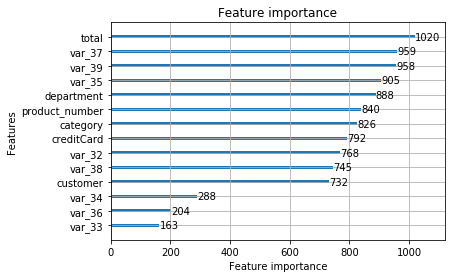

In [32]:
ax = lgb.plot_importance(clf)
plt.show()

# second submission

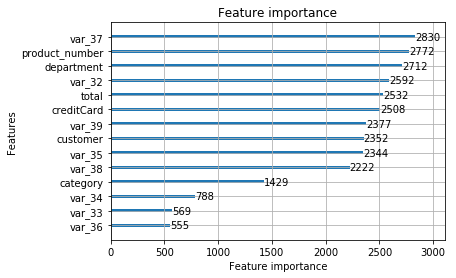

In [44]:
ax = lgb.plot_importance(clf)
plt.show()

# best one

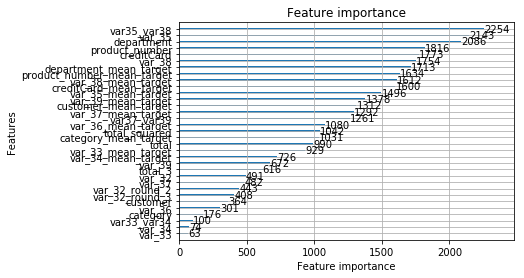

In [14]:
ax = lgb.plot_importance(clf)
plt.show()

In [5]:
train_df["var_32_round_2"]=round(train_df.var_32,2)
train_df["var_32_round_3"]=round(train_df.var_32,3)
test_df["var_32_round_2"]=round(test_df.var_32,2)
test_df["var_32_round_3"]=round(test_df.var_32,3)
train_df["total_squared"]=train_df.total**2
test_df["total_squared"]=test_df.total**2
train_df["total_3"]=train_df.total**3
test_df["total_3"]=test_df.total**3
train_df["var35_var38"]=train_df.var_35*train_df.var_38
test_df["var35_var38"]=test_df.var_35*test_df.var_38
train_df["var33_var34"]=train_df.var_33*train_df.var_34
test_df["var33_var34"]=test_df.var_33*test_df.var_34
train_df["var37_var39"]=train_df.var_37*train_df.var_39
test_df["var37_var39"]=test_df.var_37*test_df.var_39
print(train_df.shape)
print(test_df.shape)

(10964602, 35)
(5220160, 34)


In [7]:
cat_features

['product_number',
 'department',
 'category',
 'creditCard',
 'customer',
 'var_32',
 'var_32_round_2',
 'var_32_round_3',
 'var_33',
 'var_34',
 'var_35',
 'var_36',
 'var_37',
 'var_38',
 'var_39',
 'var35_var38',
 'var33_var34',
 'var37_var39']

In [14]:
train_df.columns

Index(['id', 'product_number', 'department', 'category', 'creditCard',
       'customer', 'var_32', 'var_33', 'var_34', 'var_35', 'var_36', 'var_37',
       'var_38', 'var_39', 'total', 'target', 'product_number_mean_target',
       'department_mean_target', 'category_mean_target',
       'creditCard_mean_target', 'customer_mean_target', 'var_33_mean_target',
       'var_34_mean_target', 'var_35_mean_target', 'var_36_mean_target',
       'var_37_mean_target', 'var_38_mean_target', 'var_39_mean_target',
       'var_32_round_2', 'var_32_round_3', 'total_squared', 'total_3',
       'var35_var38', 'var33_var34', 'var37_var39'],
      dtype='object')

In [12]:
num_cols=['product_number', 'department', 'category', 'creditCard', 'customer','var_33','var_34', 'var_35', 'var_36', 'var_37', 'var_38', 'var_39','var35_var38','var33_var34','var37_var39']                     
for col in num_cols:
    train_df[col]=train_df[col].astype('int32')

In [15]:
num_cols=['product_number', 'department', 'category', 'creditCard', 'customer','var_33','var_34', 'var_35', 'var_36', 'var_37', 'var_38', 'var_39','var35_var38','var33_var34','var37_var39']                     
for col in num_cols:
    train_df[col]=train_df[col].astype('int32')
float_cols=['product_number_mean_target',
       'department_mean_target', 'category_mean_target',
       'creditCard_mean_target', 'customer_mean_target', 'var_33_mean_target',
       'var_34_mean_target', 'var_35_mean_target', 'var_36_mean_target',
       'var_37_mean_target', 'var_38_mean_target', 'var_39_mean_target',
       'var_32_round_2', 'var_32_round_3', 'total_squared', 'total_3','total']
for col in float_cols:
    train_df[col]=train_df[col].astype('float32')

In [16]:
train_df.dtypes

id                             object
product_number                  int32
department                      int32
category                        int32
creditCard                      int32
customer                        int32
var_32                        float64
var_33                          int32
var_34                          int32
var_35                          int32
var_36                          int32
var_37                          int32
var_38                          int32
var_39                          int32
total                         float32
target                          int64
product_number_mean_target    float32
department_mean_target        float32
category_mean_target          float32
creditCard_mean_target        float32
customer_mean_target          float32
var_33_mean_target            float32
var_34_mean_target            float32
var_35_mean_target            float32
var_36_mean_target            float32
var_37_mean_target            float32
var_38_mean_

In [ ]:
features = [c for c in train_df.columns if c not in ['id', 'target']]
target = train_df['target']
param = {
    'bagging_freq': 5,          
    'bagging_fraction': 0.331,   'boost_from_average':'false',   
    'boost': 'gbdt',             'feature_fraction': 0.2,     'learning_rate': 0.083,
    'max_depth': -1,             'metric':'auc',                'min_data_in_leaf': 80,
    'num_leaves': 13,            'num_threads': 4,              'tree_learner': 'serial',   'objective': 'binary',      'verbosity': 1
}
folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=2319)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    clf = lgb.train(param, trn_data, 10000, valid_sets = [trn_data, val_data], early_stopping_rounds = 200,categorical_feature=cat_features)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    #predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration)
    #print("CV score: {:<8.5f}".format(roc_auc_score(target[val_idx], oof[val_idx])))
    break;
sub = pd.DataFrame({"id": test_df.id.values})
sub["target"] = predictions
sub.to_csv("features_interaction__80_data_mean_encoded_lgb_10000.csv", index=False)

In [15]:
submission_1=pd.read_csv("features_interaction__80_data_mean_encoded_lgb_10000.csv")
submission_2=pd.read_csv("mean_encoded_lgb_10000.csv")
final_submission=pd.DataFrame()
final_submission["id"]=submission_1["id"]
final_submission["target"]=0.8 * submission_1.target + 0.2 * submission_2.target
final_submission.head()

,id,target
0,id_5007385,0.082161
1,id_12558699,0.006706
2,id_5454443,0.013669
3,id_101507,0.028579
4,id_11803238,0.101074


In [18]:
final_submission.to_csv("final_submission_avg.csv",index=False)